## Spatial Estimation with Inverse Distance 

### Reidar B Bratvold, Professor, University of Stavanger 

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\mathbf{u}_0)$, where $z$ is the property of interest (e.g., porosity, permeability) and $\mathbf{u}_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\mathbf{𝐮}_1)$, $𝑧(\mathbf{𝐮}_2)$, and $𝑧(\mathbf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

$$
z^{*}(\mathbf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\mathbf{u}_{\alpha})
$$

We enforce an unbiasedness constraint by ensuring that the sum of the weights equals one. If we have no informative data, we estimate using the global average of the property of interest.

$$
z^{*}(\mathbf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\mathbf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
$$

We assume **stationarity**, meaning we work with residuals, $y$, defined as:

$$
y^{*}(\mathbf{u}) = z^{*}(\mathbf{u}) - \overline{z}(\mathbf{u})
$$

By substituting this into our estimator, the expression simplifies since the mean of the residuals is zero:

$$
y^{*}(\mathbf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\mathbf{u}_{\alpha})
$$

This ensures **unbiased estimation** while considering local information.

---

### **Inverse Distance Weighting (IDW) – Normalized Weights**
Now the next question is: **what weights should we use?**  

Instead of assigning simple inverse distance weights, we use a **normalized weighting scheme** to ensure that the sum of all weights equals **one**:

$$
\lambda_{\alpha} = \frac{\frac{1}{d_{0,\alpha}^p}}{\sum_{i=1}^{n_s} \frac{1}{d_{0,i}^p}}
$$

where:
- $0$ is the unknown location where we are estimating a value.
- $n_s$ is the number of available neighboring data points.
- $d_{0,\alpha}$ represents the **distance** between the estimation point $u_0$ and each known data point $\alpha$.
- $p$ is the **power parameter** controlling how distance affects weighting.

---

### **Why Normalize the Weights?**
- **Without normalization**, the estimated value can be **biased** or **out of range** of the known data.
- **With normalization**, the weights become a valid **convex combination**, ensuring a proper weighted average.

---

### **Effect of Power $p$ on Weighting**
- **Lower $p$ (e.g., $p=1$)** → More influence from distant points.
- **Higher $p$ (e.g., $p=4$ or $p=6$)** → Emphasizes **closer** points, reducing distant influence.
- **$p \to \infty$** → The method approaches **nearest neighbor interpolation**.


#### Let's take a look at how the weights change with distance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Define distance range
d_0_alpha = np.linspace(1, 10, 100)  # Avoid zero to prevent division by zero

# Function to update the plot interactively
def update_plot(p=1, show_legend=True):   
    # Compute weights, handling p=0 case (equal weights)
    if p == 0:
        lambda_values = np.ones_like(d_0_alpha)  # Constant weights if p=0
    else:
        lambda_values = 1 / (d_0_alpha**p)  # Compute weights for given power

    # Create figure
    plt.figure(figsize=(12, 6))
    plt.plot(d_0_alpha, lambda_values, label=f'$\\lambda_\\alpha = 1/(d_{{0,\\alpha}}^{p})$', linewidth=2)

    # Formatting
    plt.xlabel('Distance $d_{0,\\alpha}$', fontsize=14)
    plt.ylabel('Weight $\\lambda_\\alpha$', fontsize=14)
    plt.ylim(0, 1.05)  # Extend vertical scale to 1.05
    plt.xlim(1, max(d_0_alpha))  # Limit distance range
    if show_legend:
        plt.legend(fontsize=12)
    plt.title('Inverse Distance Weighting (IDW) - Effect of Power $p$', fontsize=14)
    plt.grid(True)

    plt.show()

# Create interactive sliders and checkbox
interact(update_plot, 
         p=widgets.FloatSlider(min=0, max=10, step=0.1, value=2, description="Power (p)"),
         show_legend=widgets.Checkbox(value=True, description="Show Legend"));

interactive(children=(FloatSlider(value=2.0, description='Power (p)', max=10.0), Checkbox(value=True, descript…

In [2]:
import os                                               # to set current working directory 
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [3]:
os.chdir("/Users/reidarbbratvold/Documents/UiS/Undervisning/2025/MOD550/classes/reidar/pyrcz/univariate/code")
print(os.getcwd())

/Users/reidarbbratvold/Documents/UiS/Undervisning/2025/MOD550/classes/reidar/pyrcz/univariate/code


## Simple inverse distance weighting (IDW) example. Estimating value at a single new spatial location.

### Define functions

In [4]:
def distance_matrix(x0, y0, x1, y1):
    """Compute pairwise Euclidean distance matrix."""
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T
    d0 = np.subtract.outer(obs[:, 0], interp[:, 0])
    d1 = np.subtract.outer(obs[:, 1], interp[:, 1])
    return np.hypot(d0, d1)

def inverse_distance_weighting(x, y, z, xi, yi, power=1):
    """Perform Inverse Distance Weighting (IDW) interpolation."""
    dist = distance_matrix(x, y, [xi], [yi])
    weights = 1.0 / (dist + 1e-12) ** power
    weights /= weights.sum(axis=0)
    return np.dot(weights.T, z), dist.flatten(), weights.flatten()

def local_mean(z):
    """Compute local mean."""
    return np.mean(z)

def nearest_neighbor(x, y, z, xi, yi):
    """Perform nearest neighbor interpolation."""
    dist = distance_matrix(x, y, [xi], [yi])
    return z[np.argmin(dist)]

def create_results_table(x, y, z, xi, yi):
    dist = np.hypot(x - xi, y - yi)
    
    _, w1_dist, w1_weights = inverse_distance_weighting(x, y, z, xi, yi, power=1)
    _, w2_dist, w2_weights = inverse_distance_weighting(x, y, z, xi, yi, power=2)
    nearest_z = nearest_neighbor(x, y, z, xi, yi)
    
    df = pd.DataFrame({
        'Distance': dist.round(1),
        '1/d^p (p=0)': np.ones_like(dist),
        'Weight (p=0)': (np.ones_like(dist) / len(dist)).round(3),
        '1/d^p (p=1)': (1 / (dist + 1e-12)).round(6),
        'Weight (p=1)': w1_weights.round(3),
        '1/d^p (p=2)': (1 / (dist**2 + 1e-12)).round(6),
        'Weight (p=2)': w2_weights.round(3)
    })
    
    df.loc['Sum'] = df.sum(numeric_only=True)
    df.loc['Z='] = ["", "", local_mean(z).round(1), "", np.dot(w1_weights, z).round(1), "", np.dot(w2_weights, z).round(1)]
    df.loc['Nearest Neighbor'] = ["", "", "", "", "", "", nearest_z]
    
    return df.style.set_table_attributes("style='display:inline'" )\
                      .set_caption("<b>Interpolation Results Table</b>")\
                      .set_properties(**{'text-align': 'center'})\
                      .set_table_styles([
                          {'selector': 'th', 'props': [('background-color', '#d5f5e3'), ('text-align', 'center')]},
                          {'selector': 'td', 'props': [('border', '1px solid black'), ('padding', '5px')]}
                      ])



### Example data

In [5]:
# Example data
x = np.array([2500, 2800, 2500, 2900]) # x location values of data points
y = np.array([3900, 3700, 3200, 3100]) # y location-values of data points
z = np.array([31, 25, 38, 14]) # variable values of data points
xi, yi = 2600, 3400 # x, y loction of point where we want to calculate the varaible value


### Compute the IDW estimates

In [6]:
# Compute estimates
lm = local_mean(z)
idw1, _, _ = inverse_distance_weighting(x, y, z, xi, yi, power=1)
idw2, _, _ = inverse_distance_weighting(x, y, z, xi, yi, power=2)
nn = nearest_neighbor(x, y, z, xi, yi)

# Print results
print(f"Local Mean (p=0): {lm}")
print(f"Inverse Distance (p=1): {round(idw1.item(), 3)}")
print(f"Inverse Distance Squared (p=2): {round(idw2.item(), 3)}")
print(f"Nearest Neighbor (p=∞): {nn}")


Local Mean (p=0): 27.0
Inverse Distance (p=1): 28.803
Inverse Distance Squared (p=2): 30.984
Nearest Neighbor (p=∞): 38


### Generate table with results

In [7]:
# Generate and display table
df_results = create_results_table(x, y, z, xi, yi)
df_results

,Distance,1/d^p (p=0),Weight (p=0),1/d^p (p=1),Weight (p=1),1/d^p (p=2),Weight (p=2)
0,509.900000,1.000000,0.250000,0.001961,0.170000,0.000004,0.104000
1,360.600000,1.000000,0.250000,0.002774,0.240000,0.000008,0.207000
2,223.600000,1.000000,0.250000,0.004472,0.387000,0.000020,0.539000
3,424.300000,1.000000,0.250000,0.002357,0.204000,0.000006,0.150000
Sum,1518.400000,4.000000,1.000000,0.011564,1.001000,0.000038,1.000000
Z=,,,27.000000,,28.800000,,31.000000
Nearest Neighbor,,,,,,,38.000000


## Let's look at a more general context where we want to calculate thickness values across a 2D area.

### Specify grid size

In [8]:
# size of the grid to interpolate
nx, ny = 50, 50 

# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)

# generate grid 
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

### Define functions needed

In [9]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

In [10]:
def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)

In [11]:
def plot(x,y,z,grid):
    """ Plot the input points and the result """
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()), cmap='rainbow', interpolation='gaussian')
    plt.scatter(x,y,c=z, cmap='rainbow', edgecolors='black')
    plt.colorbar()

### Example use

In [12]:
import ipywidgets as widgets
from IPython.display import display

def update_idw(power):
    grid = simple_idw(x, y, z, xi, yi, power=power).reshape((ny, nx))
    plot(x, y, z, grid)
    plt.title(f'IDW with Power = {power}')
    plt.show()

widgets.interact(update_idw, power=widgets.IntSlider(min=0, max=10, step=1, value=2));


interactive(children=(IntSlider(value=2, description='power', max=10), Output()), _dom_classes=('widget-intera…

- p = 0, Flat, uniform estimate (global mean)

- p = 1, Distant points still contributing somewhat

- p = 2, Nearby points dominate more

- p = 10, Almost like nearest neighbor interpolation

## Example 2 - a bit richer

In [13]:

def generate_random_data(n):
    """Generate random (x, y, z) data points."""
    x, y, z = np.random.random(n), np.random.random(n), np.random.random(n)
    return x, y, z

def create_grid(x, y, nx=50, ny=50):
    """Create a mesh grid for interpolation."""
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    return np.meshgrid(xi, yi)

def distance_matrix(x0, y0, x1, y1):
    """Compute pairwise Euclidean distance matrix."""
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T
    d0 = np.subtract.outer(obs[:, 0], interp[:, 0])
    d1 = np.subtract.outer(obs[:, 1], interp[:, 1])
    return np.hypot(d0, d1)

def inverse_distance_weighting(x, y, z, xi, yi, power=1):
    """Perform Inverse Distance Weighting (IDW) interpolation."""
    dist = distance_matrix(x, y, xi, yi)
    weights = 1.0 / (dist + 1e-12) ** power
    weights /= weights.sum(axis=0)
    return np.dot(weights.T, z)

def plot_idw_results(x, y, z, grids, xi, yi, powers):
    """Plot IDW results in a 2x2 grid for different power values."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    titles = [f"IDW power={p}" for p in powers]
    
    # Ensure xi and yi are numpy arrays
    xi, yi = np.array(xi), np.array(yi)

    for ax, grid, title in zip(axes.flatten(), grids, titles):
        im = ax.imshow(grid, extent=(xi.min(), xi.max(), yi.max(), yi.min()), 
                       cmap='rainbow', interpolation='gaussian', origin='lower')
        ax.scatter(x, y, c=z, cmap='rainbow', edgecolors='black')
        ax.set_title(title)
        ax.set_xticks(np.arange(0.1, 1.0, 0.1))
        ax.set_yticks(np.linspace(0.1, 0.8, 8))
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()


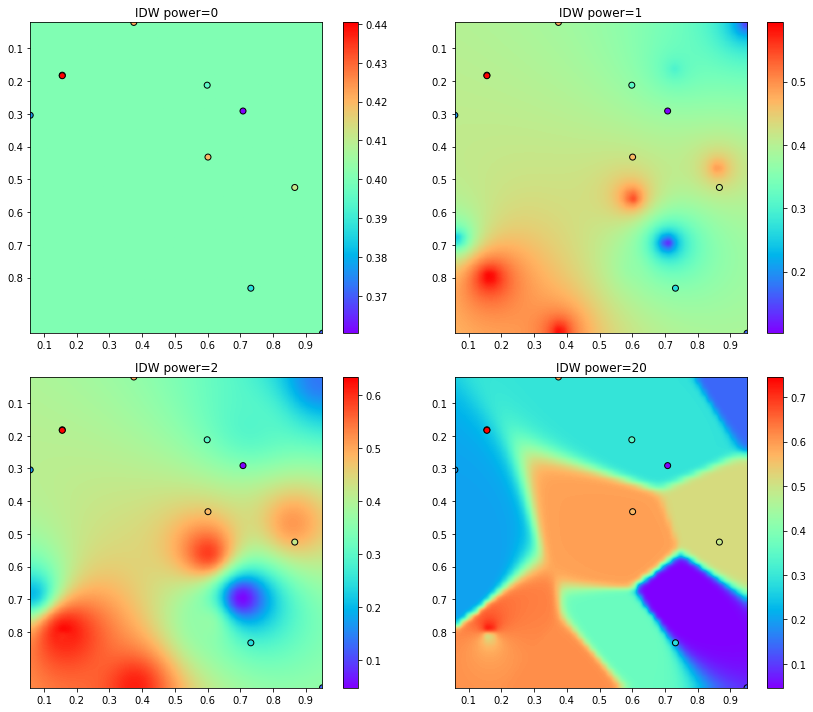

In [14]:
# Parameters
np.random.seed(42)
n = 10
nx, ny = 50, 50

# Generate data
x, y, z = generate_random_data(n)
xi, yi = create_grid(x, y, nx, ny)
xi, yi = np.array(xi.flatten()), np.array(yi.flatten())

# Perform IDW interpolation with different power values
powers = [0, 1, 2, 20]

grids = [inverse_distance_weighting(x, y, z, xi, yi, power=p).reshape((ny, nx)) for p in powers]

# Plot results
plot_idw_results(x, y, z, grids, xi, yi, powers)


### The effects of p

- **Small p (e.g., p = 1)**: Distant points still contribute, making the interpolation smooth.

- **Moderate p (e.g., p = 2)**: Closer points dominate, but some smoothing remains.

- **Very Large p (e.g., p = 20)**: Weights decay so rapidly that the closest known point has almost all the weight, while all other points contribute nearly zero weight.

#### Function to compute the weighted estimate at each grid point.

In [21]:
import scipy.spatial as sp  # for fast nearest neighbor search

def inv_dist_estimation(
    df,
    xcol,
    ycol,
    vcol,
    tmin,
    tmax,
    nx,
    xmn,
    xsiz,
    ny,
    ymn,
    ysiz,
    ndmin,
    ndmax,
    radius,
    power
):
    """ Perform Inverse Distance Weighting (IDW) estimation. """
    UNEST = -999.
    EPSLON = 1.0e-10
        
    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # Trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
    # Allocate memory
    estmap = np.full((nx, ny), UNEST)
    
    # Create KDTree for fast nearest neighbor search
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
    # Iterate over grid points
    for iy in range(ny):
        yloc = ymn + iy * ysiz  
        for ix in range(nx):
            xloc = xmn + ix * xsiz
            current_node = (yloc, xloc)
            
            # Find nearest samples
            dist, nums = tree.query(current_node, ndmax)
            mask = dist < radius
            nums = nums[mask]
            dist = dist[mask] 
            nd = len(dist)
            
            # Check if there are enough samples
            if nd < ndmin:
                estmap[ny - iy - 1, ix] = UNEST
            else:
                vra = vr[nums]
                dist = np.sqrt((x[nums] - xloc) ** 2 + (y[nums] - yloc) ** 2)
                weights = 1 / ((dist + EPSLON) ** power)
                weights /= np.sum(weights)  # Normalize weights
                estmap[ny - iy - 1, ix] = np.sum(weights * vra)
    
    return estmap



#### Check the impact of using different powers.

In [36]:

import ipywidgets as widgets
from IPython.display import display
import scipy.spatial as sp  # for fast nearest neighbor search

# Inverse Distance Weighting (IDW) Function
def inv_dist_estimation(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power):
    """ Perform Inverse Distance Weighting (IDW) estimation. """
    UNEST = -999.
    EPSLON = 1.0e-10
        
    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
    # Allocate memory
    estmap = np.full((nx, ny), UNEST)
    
    # Create KDTree for fast nearest neighbor search
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
    # Iterate over grid points
    for iy in range(ny):
        yloc = ymn + iy * ysiz  
        for ix in range(nx):
            xloc = xmn + ix * xsiz
            current_node = (yloc, xloc)
            
            # Find nearest samples
            dist, nums = tree.query(current_node, ndmax)
            mask = dist < radius
            nums = nums[mask]
            dist = dist[mask] 
            nd = len(dist)
            
            # Check if there are enough samples
            if nd < ndmin:
                estmap[ny - iy - 1, ix] = UNEST
            else:
                vra = vr[nums]
                dist = np.sqrt((x[nums] - xloc) ** 2 + (y[nums] - yloc) ** 2)
                weights = 1 / ((dist + EPSLON) ** power)
                weights /= np.sum(weights)  
                estmap[ny - iy - 1, ix] = np.sum(weights * vra)
    
    return estmap

# Function to plot estimation maps
def plot_estimation_map(est_map, xmin, xmax, ymin, ymax, xsiz, vmin, vmax, df, x_col, y_col, value_col, title, cmap):
    """ Plot the estimated IDW map. """
    plt.figure(figsize=(10, 6))  
    im = plt.imshow(est_map, extent=(xmin, xmax, ymin, ymax), cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    plt.scatter(df[x_col], df[y_col], c=df[value_col], cmap=cmap, edgecolors='black', s=50)
    plt.colorbar(im, label='Interpolated Value')
    plt.title(title, fontsize=14)
    plt.xlabel('X (m)', fontsize=12)
    plt.ylabel('Y (m)', fontsize=12)
    plt.grid(True)
    plt.show()

# Example data
x = [250,600,800,400]
y = [800,500,700,100]
vr = [1.0,2.0,3.0,4.0]
dftest2 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

# Grid parameters
tmin, tmax = -9999.9, 9999.9
nx, xsiz, xmn = 100, 10.0, 5.0
xmin, xmax = xmn - 0.5 * xsiz, xmn + nx * xsiz
ny, ysiz, ymn = 100, 10.0, 5.0
ymin, ymax = ymn - 0.5 * ysiz, ymn + ny * ysiz
ndmin, ndmax = 1, 100
radius = 10000.0

# Interactive function to update plots
def update_idw(power):
    est_map = inv_dist_estimation(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)
    plot_estimation_map(est_map, xmin, xmax, ymin, ymax, xsiz, 0.0, 4.0, dftest2, 'X', 'Y', 'Var', f'Inverse Distance Weighting (Power = {power})', plt.cm.plasma)

# Create interactive widget
widgets.interact(update_idw, power=widgets.IntSlider(min=0, max=10, step=1, value=2));


interactive(children=(IntSlider(value=2, description='power', max=10), Output()), _dom_classes=('widget-intera…

### Check the Impact of different search radii.

Radius is the maximum distance to look for neighbouring data

* limited radius may result is image artifacts as data abruptly are excluded

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import scipy.spatial as sp  # for fast nearest neighbor search

# Inverse Distance Weighting (IDW) Function
def inv_dist_estimation(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power):
    """ Perform Inverse Distance Weighting (IDW) estimation. """
    UNEST = -999.
    EPSLON = 1.0e-10
        
    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
    # Allocate memory
    estmap = np.full((nx, ny), UNEST)
    
    # Create KDTree for fast nearest neighbor search
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
    # Iterate over grid points
    for iy in range(ny):
        yloc = ymn + iy * ysiz  
        for ix in range(nx):
            xloc = xmn + ix * xsiz
            current_node = (yloc, xloc)
            
            # Find nearest samples
            dist, nums = tree.query(current_node, ndmax)
            mask = dist < radius
            nums = nums[mask]
            dist = dist[mask] 
            nd = len(dist)
            
            # Check if there are enough samples
            if nd < ndmin:
                estmap[ny - iy - 1, ix] = UNEST
            else:
                vra = vr[nums]
                dist = np.sqrt((x[nums] - xloc) ** 2 + (y[nums] - yloc) ** 2)
                weights = 1 / ((dist + EPSLON) ** power)
                weights /= np.sum(weights)  
                estmap[ny - iy - 1, ix] = np.sum(weights * vra)
    
    return estmap

# Function to plot estimation maps
def plot_estimation_map(est_map, xmin, xmax, ymin, ymax, xsiz, vmin, vmax, df, x_col, y_col, value_col, title, cmap):
    """ Plot the estimated IDW map. """
    plt.figure(figsize=(10, 6))  
    im = plt.imshow(est_map, extent=(xmin, xmax, ymin, ymax), cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    plt.scatter(df[x_col], df[y_col], c=df[value_col], cmap=cmap, edgecolors='black', s=50)
    plt.colorbar(im, label='Interpolated Value')
    plt.title(title, fontsize=14)
    plt.xlabel('X (m)', fontsize=12)
    plt.ylabel('Y (m)', fontsize=12)
    plt.grid(True)
    plt.show()

# Generate data
x = [250,600,800,400]
y = [800,500,700,100]
vr = [1.0,2.0,3.0,4.0]
dftest3 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

# Define grid and IDW parameters
tmin, tmax = -9999.9, 9999.9
nx, xsiz, xmn = 100, 10.0, 5.0
xmin, xmax = xmn - 0.5 * xsiz, xmn + nx * xsiz
ny, ysiz, ymn = 100, 10.0, 5.0
ymin, ymax = ymn - 0.5 * ysiz, ymn + ny * ysiz
ndmin, ndmax = 1, 100
power = 2  # Fixed power, changing radius interactively

# Interactive function to update plots
def update_idw(radius):
    est_map = inv_dist_estimation(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)
    plot_estimation_map(est_map, xmin, xmax, ymin, ymax, xsiz, 0.0, 4.0, dftest3, 'X', 'Y', 'Var', f'IDW with Radius = {radius}', plt.cm.plasma)

# Create interactive widget
widgets.interact(update_idw, radius=widgets.IntSlider(min=50, max=5000, step=50, value=1000, description="Search Radius"));


interactive(children=(IntSlider(value=1000, description='Search Radius', max=5000, min=50, step=50), Output())…

## Interpretation of IDW Interpolation Maps with Different Search Radii

The above maps show the effect of **different search radii** when performing **Inverse Distance Weighting (IDW) interpolation** with **power = 2**. Below is an explanation of each:

---

### **1. Left Map (Radius = 100m)**
- The **blue background** represents **unestimated regions** where no data points fall within the search radius.
- Each colored **circular zone** represents the area where at least one data point was used for estimation.
- Since the radius is very small (**100 m**), each estimated zone is highly localized around individual data points.
- The transition between colors is sharp because each area is dominated by a single data point.

#### **Interpretation:**
- Only data points within **100 meters** contribute to an estimate.
- This leads to **patchy interpolation**, with large areas remaining unestimated.

---

### **2. Middle Map (Radius = 500m)**
- More of the grid is estimated compared to **Radius = 100m**.
- The influence of each data point **extends farther**, leading to **overlapping interpolation zones**.
- There are still some sharp boundaries, but transitions between colors are smoother.

#### **Interpretation:**
- Data points up to **500 meters** away contribute to the estimate.
- The estimated field is **more continuous**, but some areas remain unestimated (blue regions).

---

### **3. Right Map (Radius = 2000m)**
- The entire grid is now covered because the radius is **large enough to always include multiple points**.
- The interpolation is **much smoother** since **many data points contribute** to each estimate.
- The transition between values is gradual, and there are no missing regions.

#### **Interpretation:**
- The influence of each point **spreads further** across the grid.
- The interpolation closely resembles **a smooth surface** rather than distinct zones.

---

### **Key Takeaways**
- **Small radius (100 m)** → localized estimates, patchy results, missing data.
- **Medium radius (500 m)** → more coverage but still localized effects.
- **Large radius (2000 m)** → smooth, continuous estimation.

### **How to Choose the Best Radius?**
- If you need **localized** estimates → use **small radius**.
- If you want a **balance between local and global effects** → use **medium radius**.
- If you need a **smooth global estimate** → use **large radius**.

## More realistic examples


### Data Set

* sample_data_MV_biased.csv

### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

In [26]:
df = pd.read_csv("sample_data_MV_biased.csv")                     # read a .csv file in as a DataFrame
df.head()                                               # we could also use this command for a table preview 

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236


In [27]:
df.describe().transpose() # summary table of all DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,368.0,293.260870,169.058258,0.000000,150.500000,296.000000,439.500000,586.000000
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
Perm,368.0,85.617362,228.362654,0.094627,2.297348,10.377292,50.581288,1991.097723
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


Let's also look at the distributions.  

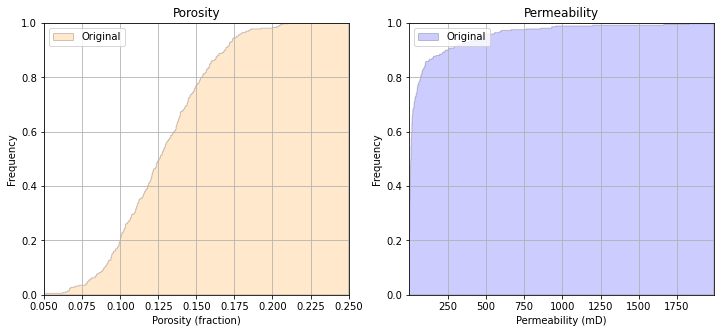

In [28]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Porosity histogram (Cumulative Density)
axes[0].hist(df['Porosity'], facecolor='darkorange', bins=np.linspace(0.0, 0.25, 1000), 
             histtype="stepfilled", alpha=0.2, density=True, cumulative=True, 
             edgecolor='black', label='Original')
axes[0].set_xlim([0.05, 0.25])
axes[0].set_ylim([0, 1.0])
axes[0].set_xlabel('Porosity (fraction)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Porosity')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot Permeability histogram (Cumulative Density)
axes[1].hist(df['Perm'], facecolor='blue', bins=np.linspace(min(df['Perm']), max(df['Perm']), 1000), 
             histtype="stepfilled", alpha=0.2, density=True, cumulative=True, 
             edgecolor='black', label='Original')
axes[1].set_xlim([min(df['Perm']), max(df['Perm'])])
axes[1].set_ylim([0, 1.0])
axes[1].set_xlabel('Permeability (mD)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Permeability')
axes[1].legend(loc='upper left')
axes[1].grid(True)

- The Permeability (Perm) variable is highly skewed, meaning a few large values dominate the dataset.

- This makes the cumulative distribution to rise sharply, making it look less S-shaped and more step-like.

- Solution: Log Transformation. We can improve visualization by spreading out the data using a log10 transformation to permeability:

$$
\log Perm = \log_{10}(Perm + 1)
$$

(Adding 1 avoids issues with log(0).)

- This makes the distribution more evenly spread and results in a more gradual, S-shaped cumulative histogram.

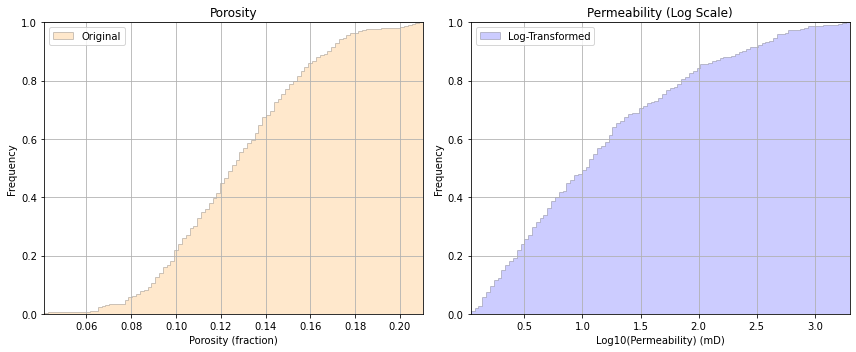

In [29]:
# Extract relevant columns
porosity = df['Porosity']
permeability = df['Perm']

# Apply log transformation to Permeability
log_permeability = np.log10(permeability + 1)  # Adding 1 to avoid log(0)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Porosity histogram (Cumulative Density)
axes[0].hist(porosity, facecolor='darkorange', bins=np.linspace(porosity.min(), porosity.max(), 100), 
             histtype="stepfilled", alpha=0.2, density=True, cumulative=True, 
             edgecolor='black', label='Original')
axes[0].set_xlim([porosity.min(), porosity.max()])
axes[0].set_ylim([0, 1.0])
axes[0].set_xlabel('Porosity (fraction)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Porosity')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot Permeability histogram (Cumulative Density) with log-transformed values
axes[1].hist(log_permeability, facecolor='blue', bins=np.linspace(log_permeability.min(), log_permeability.max(), 100), 
             histtype="stepfilled", alpha=0.2, density=True, cumulative=True, 
             edgecolor='black', label='Log-Transformed')
axes[1].set_xlim([log_permeability.min(), log_permeability.max()])
axes[1].set_ylim([0, 1.0])
axes[1].set_xlabel('Log10(Permeability) (mD)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Permeability (Log Scale)')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

We can observe from the CDFs that the porosity distribution is 'Gaussian-like' in shape, while the permeability distribution is 'lognormal-like'.  They both look well behaved.

For brevity we will omit data declustering from this workflow. We will assume declustered means for the porosity and permeability to apply with simple kriging.

Let's plot the location maps of porosity and permeability for all facies. We will also include a cross plot of permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

First we need a function to plot location maps

In [30]:
def plot_location_map(df, x_col, y_col, value_col, x_min, x_max, y_min, y_max, v_min, v_max, title, x_label, y_label, colorbar_label, cmap):
    """Plot a location map replacing the GSLIB function."""
    plt.figure(figsize=(8, 6))
    
    sc = plt.scatter(df[x_col], df[y_col], c=df[value_col], cmap=cmap, edgecolors='k', vmin=v_min, vmax=v_max)
    plt.colorbar(sc, label=colorbar_label)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.5, hspace=0.3)
    plt.show()


Then we use it to generate a location map for porosity

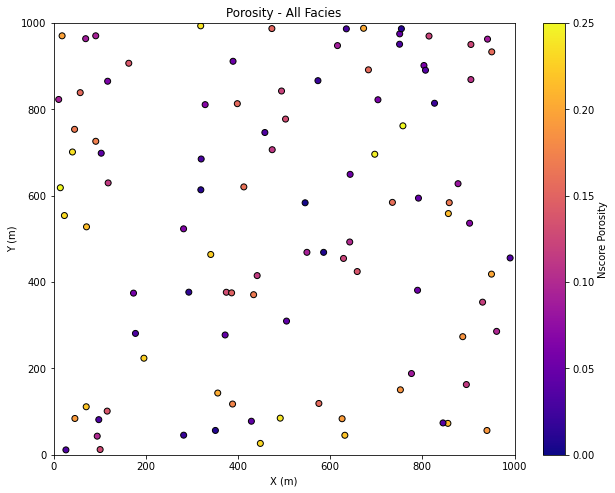

In [31]:

cmap = plt.cm.plasma  # Color map

# Dummy DataFrame for testing
data = {
    'X': np.random.uniform(0, 1000, 100),
    'Y': np.random.uniform(0, 1000, 100),
    'Porosity': np.random.uniform(0, 0.25, 100)
}
df = pd.DataFrame(data)

# Plot location map
plot_location_map(df, 'X', 'Y', 'Porosity', 0, 1000, 0, 1000, 0, 0.25,
                  'Porosity - All Facies', 'X (m)', 'Y (m)', 'Nscore Porosity', cmap)

#### Inverse Distance

To demonstrate inverse distance, we include a inverse distance function.  

#### Function to compute the weighted estimate at each grid point.

In [32]:
import scipy.spatial as sp  # for fast nearest neighbor search

def inv_dist_estimation(
    df,
    xcol,
    ycol,
    vcol,
    tmin,
    tmax,
    nx,
    xmn,
    xsiz,
    ny,
    ymn,
    ysiz,
    ndmin,
    ndmax,
    radius,
    power
):
    """ Perform Inverse Distance Weighting (IDW) estimation. """
    UNEST = -999.
    EPSLON = 1.0e-10
        
    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # Trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
    # Allocate memory
    estmap = np.full((nx, ny), UNEST)
    
    # Create KDTree for fast nearest neighbor search
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
    # Iterate over grid points
    for iy in range(ny):
        yloc = ymn + iy * ysiz  
        for ix in range(nx):
            xloc = xmn + ix * xsiz
            current_node = (yloc, xloc)
            
            # Find nearest samples
            dist, nums = tree.query(current_node, ndmax)
            mask = dist < radius
            nums = nums[mask]
            dist = dist[mask] 
            nd = len(dist)
            
            # Check if there are enough samples
            if nd < ndmin:
                estmap[ny - iy - 1, ix] = UNEST
            else:
                vra = vr[nums]
                dist = np.sqrt((x[nums] - xloc) ** 2 + (y[nums] - yloc) ** 2)
                weights = 1 / ((dist + EPSLON) ** power)
                weights /= np.sum(weights)  # Normalize weights
                estmap[ny - iy - 1, ix] = np.sum(weights * vra)
    
    return estmap


Function to Define grid and IDW parameters

In [33]:
# Define grid and IDW parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 2000
power = 2

# Compute estimation map for Porosity
invdist_map_porosity = inv_dist_estimation(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2) 
plt.show()

<Figure size 432x288 with 0 Axes>

### Test method.


## Inverse Distance Porosity Map

Starting with the a data file, we can build a map of the porosity spatial feature.

* try experimenting with various powers and radii

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

def plot_estimation_maps(est_maps, xmin, xmax, ymin, ymax, xsiz, vmin, vmax, df, x_col, y_col, value_col, titles, cmap):
    """
    Plot estimated maps, handling both single and multiple maps.

    Parameters:
    - est_maps (list or np.array): List of estimated maps (2D NumPy arrays).
    - xmin, xmax, ymin, ymax (float): Grid boundaries.
    - xsiz (float): Grid cell size in the x-direction.
    - vmin, vmax (float): Min and max values for color mapping.
    - df (pd.DataFrame): DataFrame containing the original data points.
    - x_col, y_col, value_col (str): Column names for coordinates and values.
    - titles (list): List of subplot titles.
    - cmap (matplotlib colormap): Colormap to use for visualization.
    """
    n_maps = len(est_maps)
    fig, axes = plt.subplots(1, n_maps, figsize=(6 * n_maps, 6), constrained_layout=True)

    if n_maps == 1:
        axes = [axes]

    for ax, est_map, title in zip(axes, est_maps, titles):
        im = ax.imshow(est_map, extent=(xmin, xmax, ymin, ymax), cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
        ax.scatter(df[x_col], df[y_col], c=df[value_col], cmap=cmap, edgecolors='black', s=50)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('X (m)', fontsize=12)
        ax.set_ylabel('Y (m)', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Colorbar scaling
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label='Feature')

    plt.show()

## Inverse Distance Porosity Map

Starting with the a data file, we can build a map of the porosity spatial feature.

* try experimenting with various powers and radii

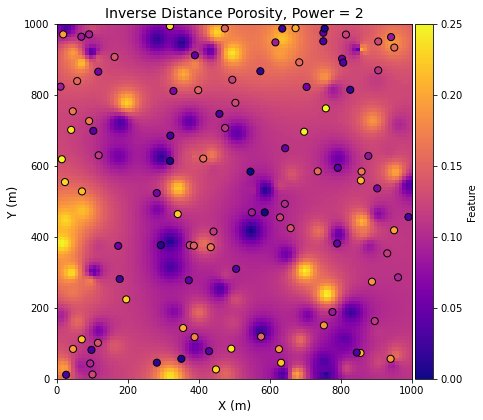

<Figure size 432x288 with 0 Axes>

In [35]:
# Define grid and IDW parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 2000
power = 2

# Compute estimation map for Porosity
invdist_map_porosity = inv_dist_estimation(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

# Plot the estimated map correctly
plot_estimation_maps(
    [invdist_map_porosity],  # Pass as a list
    xmin, xmax, ymin, ymax, xsiz, 0.0, 0.25, df, 'X', 'Y', 'Porosity',
    ['Inverse Distance Porosity, Power = ' + str(power)],  # Pass as a list
    cmap
)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2) 
plt.show()

#### Comments

This was a basic demonstration of spatial estimation. Much more could be done. 

# The End